In [340]:
import matplotlib.pyplot as plt
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, execute, Aer, visualization

In [341]:

def createLogicalQubits(numLogicalQubits):
    logicalQubits = []

    for qubit in range(numLogicalQubits):

        physicalQubits = []

        q0 = QuantumRegister(3, name='L' + str((qubit + 1)) + 'code0')
        physicalQubits.append(q0)

        q1 = QuantumRegister(3, name='L' + str((qubit + 1)) + 'code1')
        physicalQubits.append(q1)
        
        q2 = QuantumRegister(3, name='L' + str((qubit + 1)) + 'code2')
        physicalQubits.append(q2)

        physicalQubits.append(AncillaRegister(2, name='L' + str((qubit + 1)) + 'Z'))
        physicalQubits.append(AncillaRegister(2, name='L' + str((qubit + 1)) + 'X'))

        # For testing code qubits
        # physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code0meas'))
        # physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code1meas'))
        # physicalQubits.append(ClassicalRegister(3, name='L' + str(qubit +1) + 'code2meas'))

        physicalQubits.append(ClassicalRegister(2, name='L' + str(qubit +1) + 'Zmeas'))
        physicalQubits.append(ClassicalRegister(2, name='L' + str(qubit +1) + 'Xmeas'))

        logicalQubits.append(physicalQubits)
    
    return (QuantumCircuit(*[pqubit for lqubit in logicalQubits for pqubit in lqubit]), logicalQubits)

In [342]:
def getQuibitArray(logicalQubitNumber, qc):
    qubits = []
    ancillae = []

    logicalQubitNumber = logicalQubitNumber - 1
    logicalQubit = qc[logicalQubitNumber]

    for qRegister in range(3):
        for qubit in range(3):
            qubits.append(logicalQubit[qRegister][qubit])

    for aRegister in range(2):
        for ancilla in range(2):
            ancillae.append(logicalQubit[aRegister+3][ancilla])

    return qubits, ancillae

In [343]:
def applyEncoder(circuit, qubits):
    for qubit in range(len(qubits)):
        circuit.h([qubits[qubit][0][0], qubits[qubit][1][0], qubits[qubit][2][0]])
        for i in range(3):
            circuit.cx(qubits[qubit][i][0], qubits[qubit][i][1])
            circuit.cx(qubits[qubit][i][0], qubits[qubit][i][2])
            circuit.h([qubits[qubit][i][0], qubits[qubit][i][1], qubits[qubit][i][2]])
    circuit.barrier()

In [344]:
""" def applyXDetection(circuit, qubits):
    for qubit in range(len(qubits)):
        circuit.h([qubits[qubit][4][0], qubits[qubit][4][1]])
        for i in range(2):
            for j in range(9):
                if i == 0:
                    if j % 3 != 2:
                        circuit.cx(qubits[qubit][4][0], qubits[qubit][j // 3][j % 3])
                else:
                    if j % 3 != 0:
                        circuit.cx(qubits[qubit][4][1], qubits[qubit][j // 3][j % 3])
        circuit.h([qubits[qubit][4][0], qubits[qubit][4][1]])
    circuit.barrier() """

def x_stabilizers(gate_label = '   X Stabilizers'):
    gate = QuantumCircuit(11, name = gate_label)

    #Each represents a qubit we will get measurement from
    cxA = [0,1,3,4,6,7]
    cxB = [1,2,4,5,7,8]

    gate.h([9,10])

    for qubit in cxA:
        gate.cx(9, qubit)
        
    for qubit in cxB:
        gate.cx(10, qubit)

    gate.h([9,10])

    return gate

In [345]:
""" def applyZDetection(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(2):
            for j in range(3):
                circuit.cx(qubits[qubit][i][j], qubits[qubit][3][0])
        for i in range(1, 3):
            for j in range(3):
                circuit.cx(qubits[qubit][i][j], qubits[qubit][3][1])
    circuit.barrier() """

def z_stabilizers(gate_label = '   Z Stabilizers'):
    gate = QuantumCircuit(11, name = gate_label)

    #Each represents a qubit we will get measurement from
    cxA = [0,3,1,4,2,5]
    cxB = [3,6,4,7,5,8]

    for qubit in cxA:
        gate.cx(qubit, 9)
        
    for qubit in cxB:
        gate.cx(qubit, 10)

    return gate


In [346]:
def applyMeasurements(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(3, 5):
            for j in range(2):
                # For testing both code and ancilla qubits
                # circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 5][j])
                circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 2][j])

In [347]:
def applyCodeMeasurements(circuit, qubits):
    for qubit in range(len(qubits)):
        for i in range(3):
            for j in range(3):
                circuit.measure(qubits[qubit][i][j], qubits[qubit][i + 5][j])

In [348]:
def applyrandomError(circuit, qubits):
    for qubit in range(len(qubits)):
        x = random.randint(0, 2)
        y = random.randint(0, 2)
        # circuit.h(qubits[qubit][x][y])
        circuit.z(qubits[qubit][0][1])
        # circuit.x(qubits[qubit][x][y])
    circuit.barrier()

In [349]:
def correction(gate_label = 'Correction'):
    gate = QuantumCircuit(3, name = gate_label)

    gate.cx(0,1)
    gate.cx(0,2)
    gate.ccx(1,2,0)

    return gate

def applyCorrection(qc, qubitArray):
    for LQubits in qubitArray:
        qc.append(correction(), LQubits[:3])
        qc.append(correction(), LQubits[3:6])
        qc.append(correction(), LQubits[-3:])


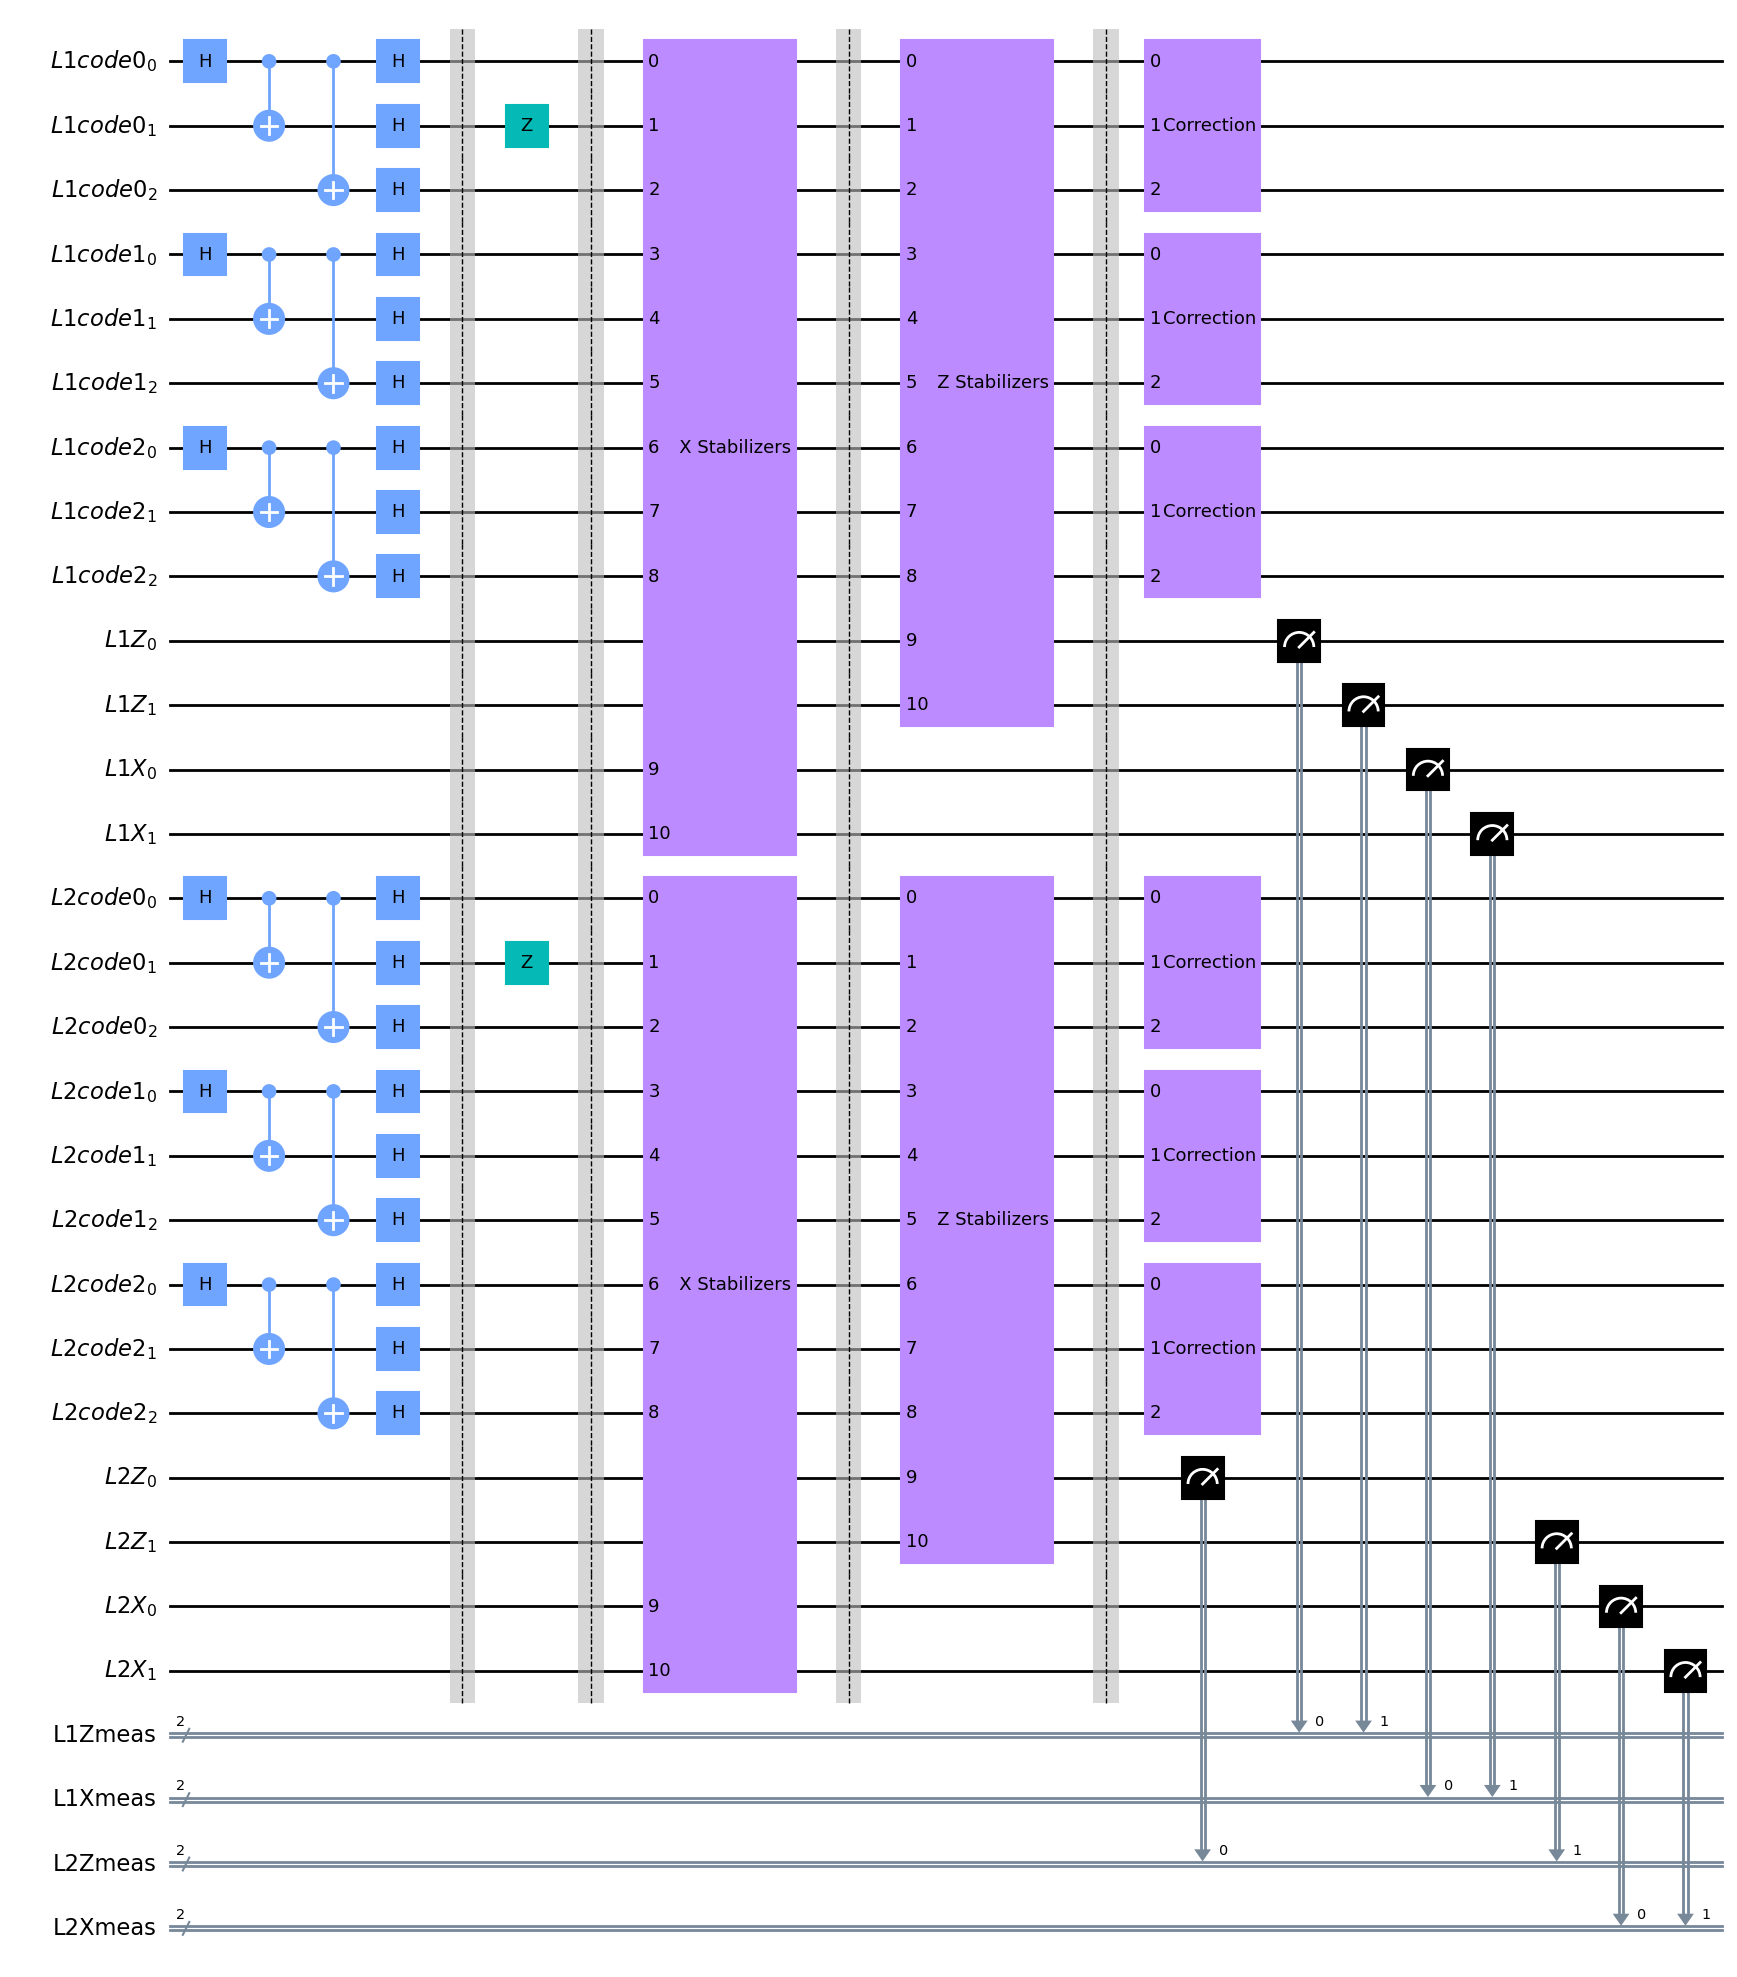

In [350]:
qc, qubits = createLogicalQubits(2)
L1Qubits, L1Ancilla = getQuibitArray(1, qubits) 
L2Qubits, L2Ancilla = getQuibitArray(2, qubits) 

applyEncoder(qc, qubits)
applyrandomError(qc, qubits)

#Apply X stabalizers to ancilla
qc.append(x_stabilizers(), L1Qubits + L1Ancilla[-2:])
qc.append(x_stabilizers(), L2Qubits + L2Ancilla[-2:])
qc.barrier() 

#Apply Z stabalizers to ancilla
qc.append(z_stabilizers(), L1Qubits + L1Ancilla[:2])
qc.append(z_stabilizers(), L2Qubits + L2Ancilla[:2])
qc.barrier() 

#Apply correction based on ????
applyCorrection(qc, [L1Qubits, L2Qubits])


#Show gates for reference
#display(x_stabilizers().draw(output='mpl'))
#display(z_stabilizers().draw(output='mpl'))
#display(correction().draw(output='mpl'))

# applyCodeMeasurements(qc, qubits)
applyMeasurements(qc, qubits)
qc.draw(output='mpl', fold=45)

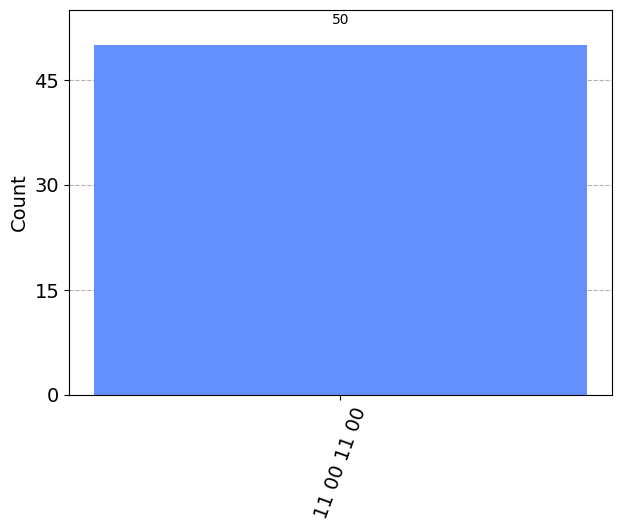

In [351]:
sim = Aer.get_backend('qasm_simulator')
job = execute(qc, sim, shots=50)
result = job.result()
counts = result.get_counts(qc)
# X stabilizers: If 01 => error is in first block of 3 code qubits, if 11 => error is in second block of 3 code qubits, if 10 => error is in third block of 3 code qubits
# Z stabilizers: If 01 => error is on 1st, 4th or 7th code qubit, if 11 => error is on 2nd, 5th or 8th code qubit, if 10 => error is on 3rd, 6th or 9th code qubit
visualization.plot_histogram(counts)

In [352]:
def cleanData(data):
    newData = {}
    for key in data:
        if key == '00 00 00 00':
            newData[key] = data[key]
    print(data)

cleanData(counts)

{'11 00 11 00': 50}
